## We will be using K-Means to group consumer complaints.

So what exactly is K-means? Well, it is an unsupervised learning algorithm (meaning there are no target labels) that allows you to identify similar groups or clusters of data points within your data. 

In this example we do have the labels but we will only us it to see how we the model performed.

## Import and munipulate the data 

In [29]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer

# Import the Consumer Complaints dataset 
dataset = pd.read_csv('Consumer_Complaints.csv')

# Only select the Product and Consumer complaint columns
col = ['Product', 'Consumer Complaint']
dataset= dataset[col]

# Drop rows with missing labels
dataset.dropna(subset=["Consumer Complaint"], inplace=True)

# Rename the Consumer Complaint column to ConsumerComplaint
dataset.columns=['Product', 'ConsumerComplaint']

# Select only only these products
dataset=dataset[dataset['Product'].isin(['Credit reporting', 'Debt collection', 'Mortgage', 'Credit card','Student loan','Bank account or service','Consumer Loan'])]

# Shuffel the dataset to make sure we get an equal distribution of the data before splitting into train and test sets
dataset = dataset.sample(frac=1)
dataset.head(10)

,Product,ConsumerComplaint
5101,Mortgage,My mortgage was sold to select portfolio servi...
6055,Credit reporting,"Equifax allowed serval Fraudulent, accounts to..."
8411,Credit reporting,The following inquires on my credit report wer...
6137,Student loan,"Dear XXXX, XXXX daughter took out a school loa..."
6338,Mortgage,"Due to our payment due date ( XXXX XXXX, 2015 ..."
8694,Credit reporting,"Tried to open an account at creditkarma.com, a..."
3646,Student loan,My loan has been transferred to several differ...
4272,Debt collection,"I went with another cell carrier in XXXX, 2016..."
2898,Mortgage,I was approved for a trial modification that h...
1865,Credit reporting,I have been disputing this information for the...


## Plot the data

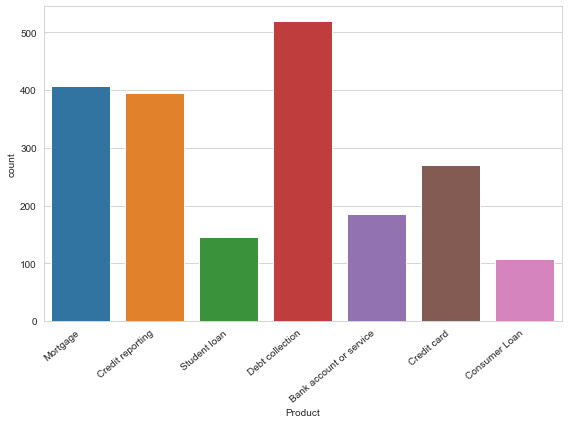

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Product', data=dataset)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()

## Clean the data

We need to remove stop words, numbers, unnecessary white space or any other characters that can badly effect the outcome.

And lastly we will stem the data

In [31]:
# What does the data look like now?
dataset["ConsumerComplaint"]

5101    My mortgage was sold to select portfolio servi...
6055    Equifax allowed serval Fraudulent, accounts to...
8411    The following inquires on my credit report wer...
6137    Dear XXXX, XXXX daughter took out a school loa...
6338    Due to our payment due date ( XXXX XXXX, 2015 ...
                              ...                        
9201    I had a modification over 2 years ago. It was ...
9721    I cancelled my XXXX service on or about XXXX X...
8646    Hello, this is a supplement to my complaint ea...
2972    I am disputing DOB information reported by EQU...
9286    I did n't receive a paper copy statement for m...
Name: ConsumerComplaint, Length: 2029, dtype: object

From the above we can see that we need to convert everything to lowercase, and remove numbers and thinks like \n

Let's create a function to do most of this.

In [32]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

# Lets do some text cleanup
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
REMOVE_NUM = re.compile('[\d+]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
    text: a string
    return: modified initial string
    """
    # lowercase text
    text = text.lower() 

    # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    
    # Remove the XXXX values
    text = text.replace('x', '') 
    
    # Remove white space
    text = REMOVE_NUM.sub('', text)

    #  delete symbols which are in BAD_SYMBOLS_RE from text
    text = BAD_SYMBOLS_RE.sub('', text) 

    # delete stopwords from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    
    # removes any words composed of less than 2 or more than 21 letters
    text = ' '.join(word for word in text.split() if (len(word) >= 2 and len(word) <= 21))

    # Stemming the words
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sachi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sachi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [33]:
dataset["ConsumerComplaint"] = dataset["ConsumerComplaint"].apply(clean_text)
dataset["ConsumerComplaint"]

5101    mortgag sold select portfolio servic inc told ...
6055    equifa allow serval fraudul account report tom...
8411    follow inquir credit report author financ secu...
6137    dear daughter took school loan degre full cosi...
6338    due payment due date fall saturday chase post ...
                              ...                        
9201    modif year ago plagu misappli fund inconsist r...
9721    cancel servic return equip per instruct via re...
8646    hello supplement complaint earlier today compl...
2972    disput dob inform report equifa disput inform ...
9286    nt receiv paper copi statement capitol one cre...
Name: ConsumerComplaint, Length: 2029, dtype: object

This looks much better!

## Run TF IDF Vectorizer on the text data

Convert text features to numeric
The classifiers and learning algorithms can not directly process the text documents in their original form, as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length. Therefore, during the preprocessing step, the texts are converted to a more manageable representation.

One common approach for extracting features from text is to use the bag of words model: a model where for each document, a complaint narrative in our case, the presence (and often the frequency) of words is taken into consideration, but the order in which they occur is ignored.

Specifically, for each term in our dataset, we will calculate a measure called Term Frequency, Inverse Document Frequency, abbreviated to tf-idf. We will use sklearn.feature_extraction.text.TfidfVectorizer to calculate a tf-idf vector for each of consumer complaint narratives

In [34]:
# Run TF IDF Vectorizer on the text data

# sublinear_df is set to True to use a logarithmic form for frequency
# min_df is the minimum numbers of documents a word must be present in to be kept
# norm is set to l2, to ensure all our feature vectors have a euclidian norm of 1
# ngram_range is set to (1, 2) to indicate that we want to consider both unigrams and bigrams
# stop_words is set to "english" to remove all common pronouns ("a", "the", ...) to reduce the number of noisy features

vectorizer = TfidfVectorizer(sublinear_tf= True, min_df=10, norm='l2', ngram_range=(1, 2), stop_words='english')
X_train_vc = vectorizer.fit_transform(dataset["ConsumerComplaint"])

pd.DataFrame(X_train_vc.toarray(), columns=vectorizer.get_feature_names()).head()

,abil,abl,abl help,abl make,abl pay,abl reach,absolut,abus,accept,access,...,year later,year loan,year old,year pay,year year,yesterday,york,young,yr,zero
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.263855,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.136193,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Elbow method to select number of clusters

This method looks at the percentage of variance explained as a function of the number of clusters: One should choose a number of clusters so that adding another cluster doesn't give much better modeling of the data. More precisely, if one plots the percentage of variance explained by the clusters against the number of clusters, the first clusters will add much information (explain a lot of variance), but at some point the marginal gain will drop, giving an angle in the graph. The number of clusters is chosen at this point, hence the "elbow criterion". This "elbow" cannot always be unambiguously identified. Percentage of variance explained is the ratio of the between-group variance to the total variance, also known as an F-test. A slight variation of this method plots the curvature of the within group variance.

### Basically, number of clusters = the x-axis value of the point that is the corner of the "elbow"(the plot looks often looks like an elbow)

In [35]:
k_clusters = 10

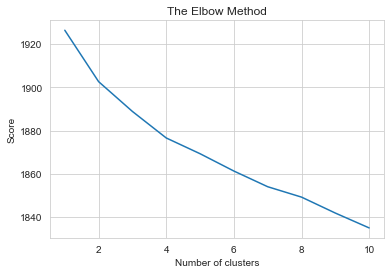

In [36]:
from sklearn.cluster import KMeans

score = []
for i in range(1,k_clusters + 1):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=5,random_state=0)
    kmeans.fit(X_train_vc)
    score.append(kmeans.inertia_)
plt.plot(range(1,k_clusters + 1 ),score)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Score')
plt.savefig('elbow.png')
plt.show()

## Train the model to find 6 clusters

We will use 6 cluster because we already know we have 6 categories, but normally you wont know this.

In [37]:
k_clusters = 6

model = KMeans(n_clusters=k_clusters, init='k-means++', n_init=10, max_iter=600, tol=0.000001, random_state=0)
model.fit(X_train_vc)

KMeans(max_iter=600, n_clusters=6, random_state=0, tol=1e-06)

## Do some predictions and display the results

In [38]:
# First: for every document we get its corresponding cluster
clusters = model.predict(X_train_vc)

In [17]:
dataset["ClusterName"] = clusters
# Convert the label (Product) to numeric using the pd factorize function 
dataset['category_id'] = dataset['Product'].factorize()[0]
dataset.head(20)

,Product,ConsumerComplaint,ClusterName,category_id
4694,Debt collection,receiv repeat call hang up associ collect agen...,3,0
285,Debt collection,winn law group continu pursu debt charg ask st...,3,0
5034,Mortgage,ditech financi servic mortgag time sold home t...,1,1
3959,Credit card,receiv letter chase indic overcharg interest r...,1,2
1790,Bank account or service,recent link well fargo account account transac...,2,3
6691,Mortgage,receiv letter home address qualiti loan servic...,1,1
4978,Debt collection,sign contract appl law group firm hope consoli...,3,0
6568,Credit reporting,previous disput transunion inaccur inform rega...,4,4
3630,Student loan,met school attend back awar respons person loa...,5,5
6497,Bank account or service,pay bill notic balanc one account less ach tra...,2,3


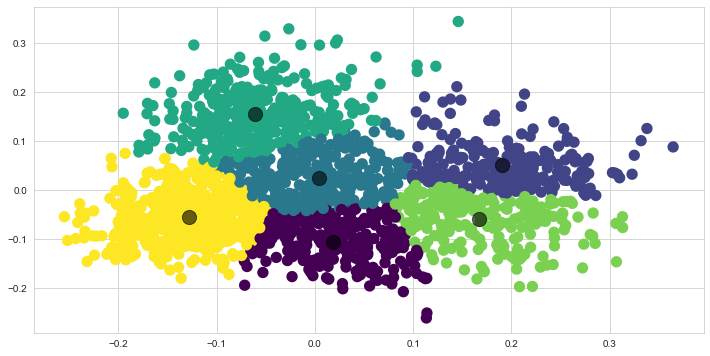

In [39]:
from sklearn.decomposition import PCA
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(X_train_vc.toarray())
kmeans = KMeans(n_clusters=k_clusters, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

plt.figure(figsize=(12, 6))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=prediction, s=40, cmap='viridis', linewidths=5)

centers = fitted.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=200, alpha=0.6);

## Top terms per cluster

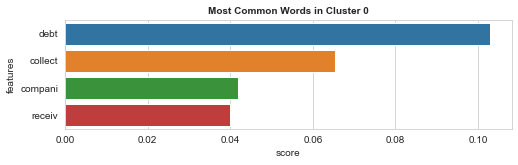

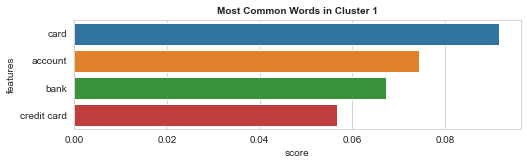

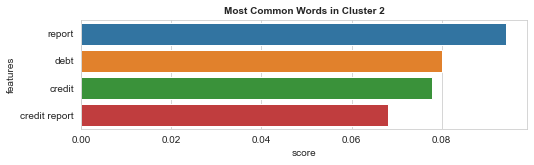

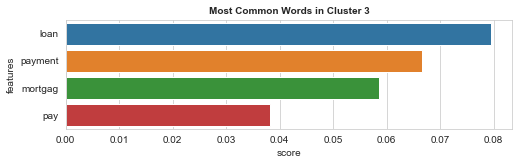

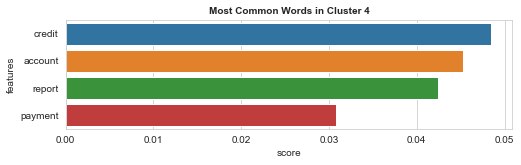

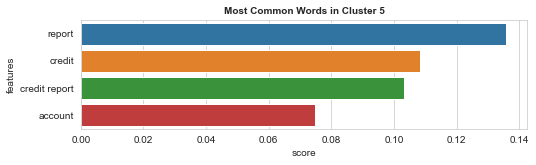

In [19]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs


def plotWords(dfs, n_feats):
    for i in range(0, len(dfs)):
        plt.figure(figsize=(8, 2))
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])

dfs = get_top_features_cluster(X_train_vc.toarray(), prediction, 4)
plotWords(dfs, 13)


In [20]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]

terms = vectorizer.get_feature_names()
for i in range(k_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :k_clusters]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Cluster 0: card credit card credit charg account use
Cluster 1: mortgag loan home modif payment bank
Cluster 2: account bank check money deposit check account
Cluster 3: debt collect receiv compani number phone
Cluster 4: report credit credit report account remov inform
Cluster 5: payment loan pay make month navient


### Make some predications

In [40]:
cleaned_data = ["I would like to change my mortgage debit order",
                "Please send me my latest credit card statement",
                "I would like to apply for a student loan"]
cleaned_data = pd.DataFrame(cleaned_data, columns=["ConsumerComplaints"])
cleaned_data = cleaned_data["ConsumerComplaints"].apply(clean_text)
predicted = model.predict(vectorizer.transform(cleaned_data))
predicted

array([3, 4, 5])

In [22]:
k_clusters = 4

model = KMeans(n_clusters=k_clusters, init='k-means++', n_init=10, max_iter=600, tol=0.000001, random_state=0)
model.fit(X_train_vc)

KMeans(max_iter=600, n_clusters=4, random_state=0, tol=1e-06)

In [23]:
clusters = model.predict(X_train_vc)

In [24]:
dataset["ClusterName"] = clusters
# Convert the label (Product) to numeric using the pd factorize function 
dataset['category_id'] = dataset['Product'].factorize()[0]
dataset.head(20)

,Product,ConsumerComplaint,ClusterName,category_id
4694,Debt collection,receiv repeat call hang up associ collect agen...,0,0
285,Debt collection,winn law group continu pursu debt charg ask st...,0,0
5034,Mortgage,ditech financi servic mortgag time sold home t...,3,1
3959,Credit card,receiv letter chase indic overcharg interest r...,3,2
1790,Bank account or service,recent link well fargo account account transac...,1,3
6691,Mortgage,receiv letter home address qualiti loan servic...,3,1
4978,Debt collection,sign contract appl law group firm hope consoli...,0,0
6568,Credit reporting,previous disput transunion inaccur inform rega...,2,4
3630,Student loan,met school attend back awar respons person loa...,3,5
6497,Bank account or service,pay bill notic balanc one account less ach tra...,1,3


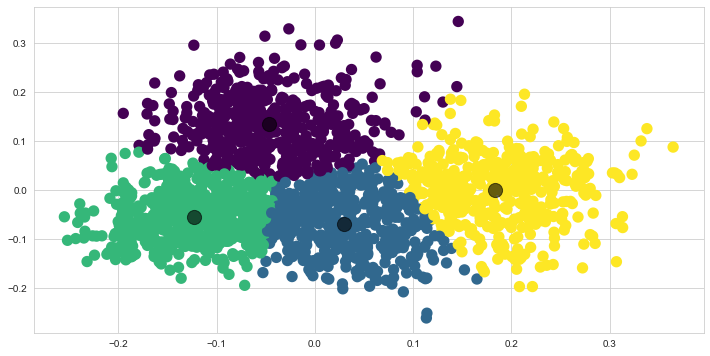

In [25]:
from sklearn.decomposition import PCA
sklearn_pca = PCA(n_components = 2)
Y_sklearn = sklearn_pca.fit_transform(X_train_vc.toarray())
kmeans = KMeans(n_clusters=k_clusters, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(Y_sklearn)
prediction = kmeans.predict(Y_sklearn)

plt.figure(figsize=(12, 6))
plt.scatter(Y_sklearn[:, 0], Y_sklearn[:, 1], c=prediction, s=40, cmap='viridis', linewidths=5)

centers = fitted.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=200, alpha=0.6);

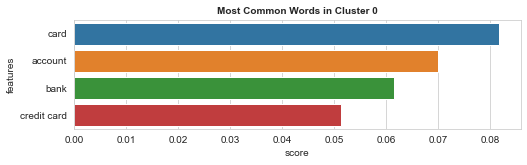

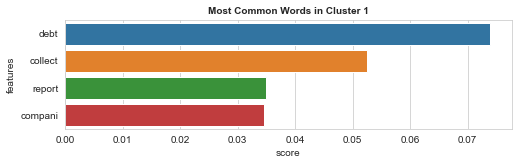

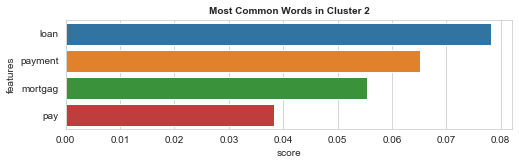

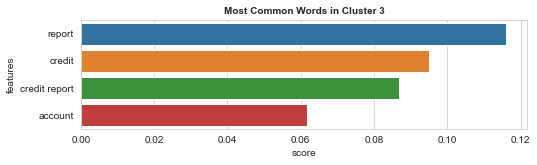

In [26]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs


def plotWords(dfs, n_feats):
    for i in range(0, len(dfs)):
        plt.figure(figsize=(8, 2))
        plt.title(("Most Common Words in Cluster {}".format(i)), fontsize=10, fontweight='bold')
        sns.barplot(x = 'score' , y = 'features', orient = 'h' , data = dfs[i][:n_feats])

dfs = get_top_features_cluster(X_train_vc.toarray(), prediction, 4)
plotWords(dfs, 13)


In [27]:
order_centroids = model.cluster_centers_.argsort()[:, ::-1]

terms = vectorizer.get_feature_names()
for i in range(k_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :k_clusters]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Cluster 0: debt collect compani receiv
Cluster 1: card account bank credit card
Cluster 2: report credit credit report account
Cluster 3: loan payment mortgag pay


In [28]:
cleaned_data = ["I would like to change my mortgage debit order",
                "Please send me my latest credit card statement",
                "I would like to apply for a student loan"]
cleaned_data = pd.DataFrame(cleaned_data, columns=["ConsumerComplaints"])
cleaned_data = cleaned_data["ConsumerComplaints"].apply(clean_text)
predicted = model.predict(vectorizer.transform(cleaned_data))
predicted

array([3, 1, 3])